# Normalizing the Muon Background (vz0)

#### Din-Ammar Tolj - Y25
Maruyama Group, Summer 2023

#### CURRENTLY WIP, not checked with Jorge if this is allowed. Don't rely too too much on this for now

In [2]:
import numpy as np

import ROOT
from ROOT import *
from root_numpy import array2hist, hist2array, fill_hist

import sys
import math

import os
import scipy
import pandas as pd
import seaborn as sns

from datetime import datetime
from glob import glob

%cd libs/
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file named dt5202.py in this folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver

from langaus import LanGausFit 
%cd -

import warnings
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.24/02
/vast/palmer/home.grace/dt592/Geant4Work/libs
/vast/palmer/home.grace/dt592/Geant4Work


In [38]:
ped = 50 #pedestal correction

# Declare constants for conversion from ADC to PE/MeV

adc_mev = 538.3933387436877 # from "MuonPeakCalibration_Din_ThanksEmily_v1_cut.ipynb"
pe_mev = 53.95 # gotten from averaging two values from "OLD_MuonsAndGammas_SimulationFitting_Din_v2_w_Caesium.ipynb"

sigma = 0.159223 # Get the sigma in MeV from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"
sigma_pe = sigma * pe_mev # Convert to PE

lin_sigma = sigma / 0.662 
lin_sigma_pe = lin_sigma * pe_mev # Convert to PE

R = 0.07
# gbins = 100 #Bins for each of the gamma lines
hmin = 0.01
hmax = 14
bins = int((hmax-hmin)/R)

In [39]:
folder_m = "/home/dt592/Geant4Work/muons_edited/muonsInPanel_build/" # location of the muon sim build folder

# Muons
muons = TFile(folder_m + "muonsJ_normalized.root", "READ")

# For the TTree for Muons
a = muons.Get("ntuple")
muonstree = a.Get("parTup")

# Append muons
muonsEnergy = []
for event in muonstree:
    muonsEnergy.append(event.Edeposited)
    
mu_mev = np.array(muonsEnergy) # muons

In [40]:
%%capture

sourceFolder = "/home/dt592/data/board1771_01192023_retestingSwirlyPanel/"

onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]

data_list = []
for file in onlyfiles:
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=100000000, num_ch=1))

data = data_list[0]
for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

In [41]:
# Convert lab data to MeV

d = data['data']['low_gain']-ped
lab_mev = (d.astype('float64'))/adc_mev # lab data in MeV

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


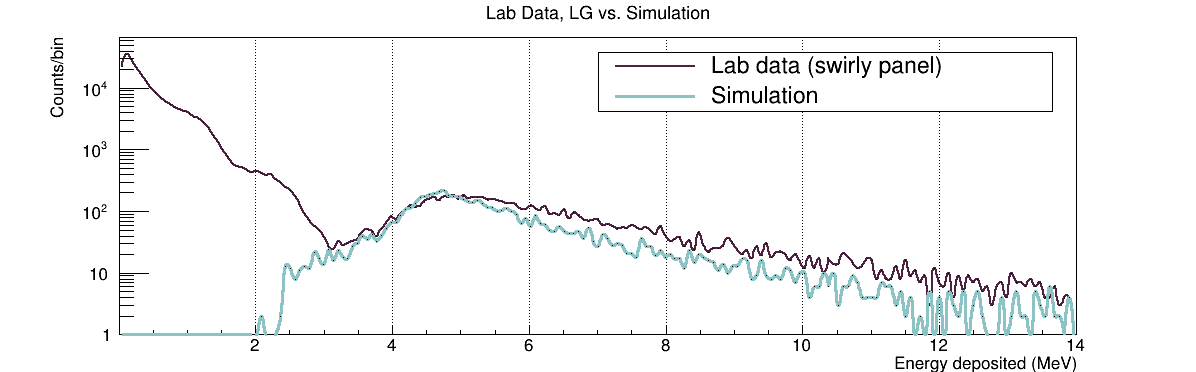

In [42]:
h_dat = TH1F('h_dat','',bins,hmin,hmax)
h_mu = TH1F('h_mu','',bins,hmin,hmax)

fill_hist(h_dat, lab_mev)
fill_hist(h_mu, mu_mev)

h_dat.Sumw2()

c1 = TCanvas('c1','',1200,400)
c1.cd()
gStyle.SetPalette(ROOT.kCandy)

h_dat.Draw("plc pcm hist")
h_dat.SetTitle("Lab Data, LG vs. Simulation")
h_dat.GetXaxis().SetTitle("Energy deposited (MeV)")
h_dat.GetXaxis().SetLabelSize(.05)
h_dat.GetXaxis().SetTitleSize(.05)
h_dat.GetYaxis().SetTitle("Counts/bin")
h_dat.GetYaxis().SetLabelSize(.05)
h_dat.GetYaxis().SetTitleSize(.05)
h_dat.GetYaxis().SetTitleOffset(.65)
h_dat.SetLineWidth(2)

h_mu.Draw("plc pcm same hist")
h_mu.SetLineWidth(3)

gPad.SetLogy()
gPad.SetGridx()
gStyle.SetOptStat(0)

legend3 = TLegend(0.5,0.7,0.88,0.86)
legend3.AddEntry(h_dat,"Lab data (swirly panel)","l")
legend3.AddEntry(h_mu,"Simulation","l")
legend3.Draw()

c1.Draw()

In [43]:
lx = int(3/R)
ux = int(14/R)
dat_int = h_dat.Integral(lx,ux)
int1 = h_mu.Integral(lx,ux)
h_mu.Scale(dat_int/int1)
h_mu.Sumw2()

Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created


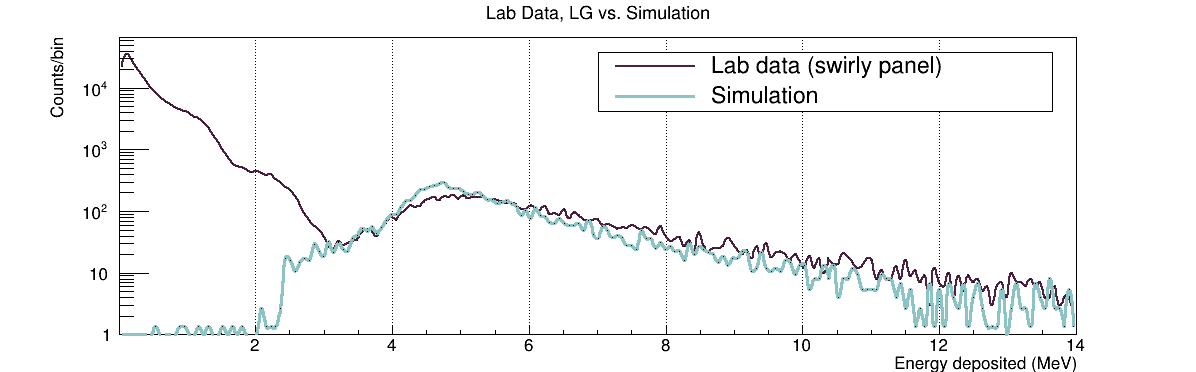

In [44]:
c1.Update()

c1.Draw()

In [45]:
mu_pe = mu_mev * pe_mev

Warning in <TFile::Append>: Replacing existing TH1: h_mu (Potential memory leak).
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


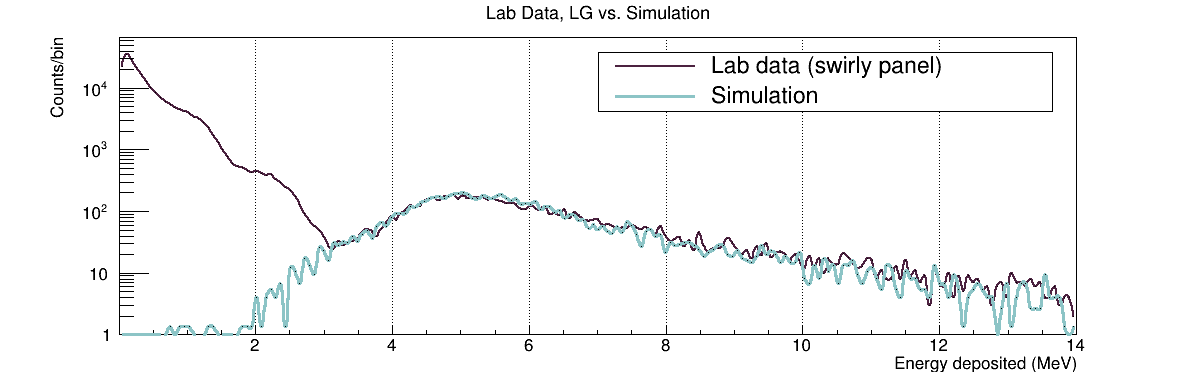

In [46]:
bg_smeared_lin_mu_pe = (
    1 + 0.004 * np.power(mu_pe,0.5)) * np.random.normal(
    loc=mu_pe, scale = 0.12 * lin_sigma_pe * np.power(mu_pe,0.5)) 

h_mu = TH1F('h_mu','',bins,hmin,hmax)
fill_hist(h_mu, bg_smeared_lin_mu_pe / pe_mev)

lx = int(3/R)
ux = int(14/R)
dat_int = h_dat.Integral(lx,ux)
int1 = h_mu.Integral(lx,ux)
h_mu.Scale(dat_int/int1)
h_mu.Sumw2()

c2 = TCanvas('c1','',1200,400)
c2.cd()
gStyle.SetPalette(ROOT.kCandy)

h_dat.Draw("plc pcm hist")

h_mu.Draw("plc pcm same hist")
h_mu.SetLineWidth(3)

gPad.SetLogy()
gPad.SetGridx()
gStyle.SetOptStat(0)

legend = TLegend(0.5,0.7,0.88,0.86)
legend.AddEntry(h_dat,"Lab data (swirly panel)","l")
legend.AddEntry(h_mu,"Simulation","l")
legend.Draw()

c2.Draw()

[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674156932637)]
((33, 0, 1.67415693e+09, 0, 1), (0, 3, 7938, 8051))
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674157533007)]
((33, 0, 1.67415753e+09, 0, 1), (0, 3, 1110, 8051))
Fit chi2/ndf = 2599.6/24 = 108.32
value0 =  0.16884744567904397  +/-  0.0036954147352985522
value1 =  0.07537592726063302  +/-  0.0011255451695424412
value2 =  0.04499417278482187  +/-  0.006435541321506699
value3 =  0.11131066892799468  +/-  0.005896069083039246
value4 =  0.0888539271477895  +/-  0.0021365354877231346
value5 =  3.704245205016221e-07  +/-  0.0011335815693852558
value6 =  0.1501483172138801  +/-  0.0048001029565616915
value7 =  5.083831022822949e-08  +/-  0.0006677950242098274
value8 =  5.5364768325461e-10  +/-  0.0003494403808751434
value9 =  0.360465884515046  +/-  0.002806940779071787
 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
  

Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TFractionFitter::Fit>: Abnormal termination of minimization.
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective e

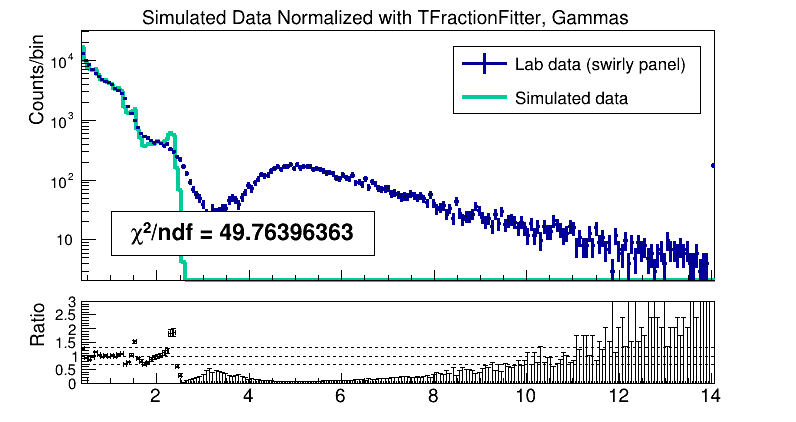

Fit chi2/ndf = 845.4/24 = 35.23
value0 =  0.29280641762138293  +/-  0.4423662510456622
value1 =  0.08020058702543797  +/-  0.06566936357780578
value2 =  0.0780921092591158  +/-  0.7795004167407058
value3 =  0.0041698143736162985  +/-  0.5151259019727561
value4 =  0.039162601583129786  +/-  0.6492256207138944
value5 =  2.83459034022826e-09  +/-  1.1989808962112747
value6 =  0.1353971349654548  +/-  0.34210639260510795
value7 =  0.0009110658729971632  +/-  0.0809564149677175
value8 =  3.350913979627279e-07  +/-  1.194856577855807
value9 =  0.369662943217563  +/-  0.054792184014380574
 **********
 **    7 **SET PRINT           0
 **********
 **********
 **    8 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 frac0        1.00000e-01  1.00000e-02    0.00000e+00  1.00000e+01
     2 frac1        1.00000e-01  1.00000e-02    0.00000e+00  1.00000e+01
     3 frac2        1.00000e-01  1.00000e-02    0.00000e+00  1.00000e+01
     4 fr

Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TFractionFitter::Fit>: Abnormal termination of minimization.
Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 eff

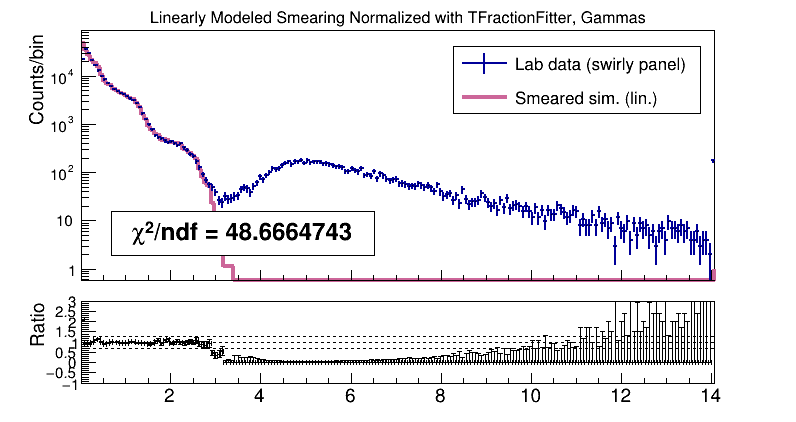

Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



In [47]:
%run Gamma_Normalization_Din_vz1.ipynb

In [48]:
# tots.Add(h_mu)

True

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c7
Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.

Info in <TCanvas::Print>: png file Test_NORMALIZED_LinSmear_FullSpec_v2.png has been created


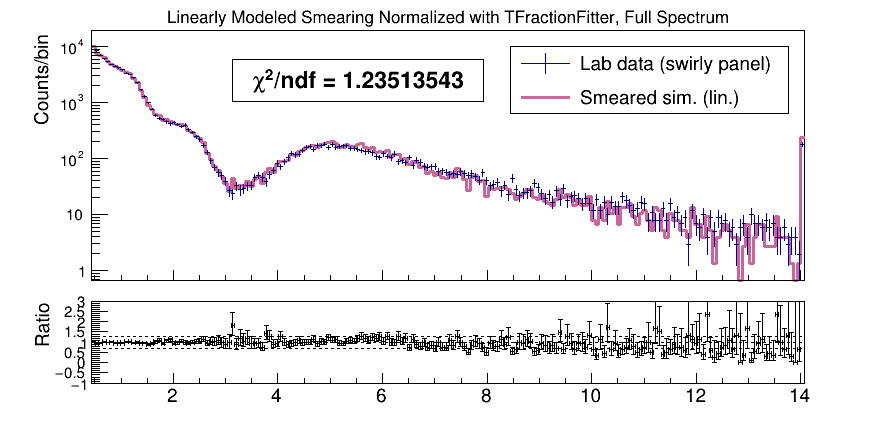

In [54]:
# c7 = TCanvas('c7','',900,450)

# # gStyle.SetPalette(kRust)
# gPad.SetLogy()
# gStyle.SetStatFontSize(.08)
# gStyle.SetTitleFontSize(0.085)
# gStyle.SetStatW(0.4)
# gStyle.SetPalette(kBird)

# h_dat.Draw("plc pmc hist")
# tots.SetTitle("Linearly Modeled Smearing Normalized with TFractionFitter, Full Spectrum")

# # tot.SetMarkerColor(kGray+1)
# # tot.SetLineColor(kGray+1)
# tots.SetLineWidth(3)
# tots.SetLineColor(kTeal - 1)
# tots.Draw("hist same")
# tots.SetAxisRange(0.5, 14, "X")
# h_dat.SetAxisRange(0.5, 14, "X")
# tots.SetLineColor(kPink+2)
# h_dat.SetLineWidth(1)
# h_dat.SetLineColor(kBlue+2)

# c7.Clear()

# rp = TRatioPlot(tots,h_dat)
# rp.Draw()

# rp.GetLowerRefYaxis().SetTitle("Ratio")
# rp.GetUpperRefYaxis().SetTitle("Counts/bin")
# rp.GetUpperRefYaxis().SetTitleOffset(0.7)
# rp.GetLowerRefYaxis().SetTitleOffset(0.7)
# rp.GetLowerRefYaxis().SetRangeUser(-1,3)

# rp.GetLowerRefYaxis().SetLabelSize(.04)
# rp.GetLowerRefYaxis().SetTitleSize(.05)
# rp.GetUpperRefYaxis().SetLabelSize(.04)
# rp.GetUpperRefYaxis().SetTitleSize(.05)
# rp.GetLowerRefXaxis().SetLabelSize(.05)
# rp.GetLowerRefXaxis().SetTitleSize(.045)

# # rp1.GetUpperPad().SetGrid()

# chi2 = " #chi^{2}/ndf = " + str(round(tots.Chi2Test(h_dat, "CHI2/NDF"), 8)) + " "

# legend = TLegend(0.57,0.73,0.88,0.89)
# legend.AddEntry(h_dat,"Lab data (swirly panel)","le")
# legend.AddEntry(tots,"Smeared sim. (lin.)","l")
# legend.Draw()

# title = TPaveText(0.26, 0.76, 0.54, 0.86, "NDC")
# title.AddText(chi2)
# title.SetMargin(0.05)
# title.SetBorderSize(1)
# title.SetFillColor(0)
# title.Draw()

# c7.Draw()

# c7.SaveAs("Test_NORMALIZED_LinSmear_FullSpec_v2.png")